In [6]:
import torch
from torchvision import models, datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

from tqdm import tqdm

from utils import WaterbirdsFullData, tsne_visualization

In [7]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = WaterbirdsFullData('waterbird_complete95_forest2water2', 'waterbird_complete95_forest2water2/metadata.csv', 'train', transform = transform)
valset = WaterbirdsFullData('waterbird_complete95_forest2water2', 'waterbird_complete95_forest2water2/metadata.csv', 'val', transform = transform)
testset = WaterbirdsFullData('waterbird_complete95_forest2water2', 'waterbird_complete95_forest2water2/metadata.csv', 'test', transform = transform)

In [8]:
batch_size = 128

trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers = 4)
valloader = DataLoader(valset, batch_size = batch_size, shuffle=False, num_workers = 4)

epochs = 10
model = models.resnet50()
model.fc = nn.Identity()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheudler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)


train_loss_history = []
val_loss_history = []
device_id = 1
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [9]:
def full_loss(features, labels, alpha=0.5, temperature = 0.5):

    ################## LSC LOSS ##################

    features = F.normalize(features, dim=1)  # Normalize features to lie on hypersphere

    similarity_matrix = torch.matmul(features, features.T) / temperature
    
    labels = labels.unsqueeze(1)
    positive_mask = (labels == labels.T).float()
    negative_mask = 1 - positive_mask

    exp_sim = torch.exp(similarity_matrix) * negative_mask
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True))
    positive_sim = (log_prob * positive_mask).sum(dim=1) / positive_mask.sum(dim=1)
    lsc_loss = -positive_sim.mean()

    ################## LSC LOSS ##################



    ################## LREP LOSS ##################

    exp_positive_sim = torch.exp(similarity_matrix) 
    repel_loss_tempo = -torch.log(exp_positive_sim.diagonal() / exp_positive_sim.sum(dim=1))
    repel_loss = repel_loss_tempo.mean()

    ################## LREP LOSS ##################

    return alpha * lsc_loss + (1 - alpha) * repel_loss

In [10]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_steps = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        features = model(images)
        loss = full_loss(features, labels)
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
    
    train_loss_history.append(train_loss / total_steps)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps
        for i, (images, labels, _) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            features = model(images)
            loss = full_loss(features, labels)
            val_loss += loss.item()
            total_steps += 1
        val_loss_history.append(val_loss / total_steps)
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}')
    scheudler.step()

100%|██████████| 38/38 [00:09<00:00,  4.03it/s]

Epoch: 0, Loss: 3.653295899692335


Epoch: 0, Val Loss: -inf


 18%|█▊        | 7/38 [00:02<00:12,  2.47it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Val Loss')

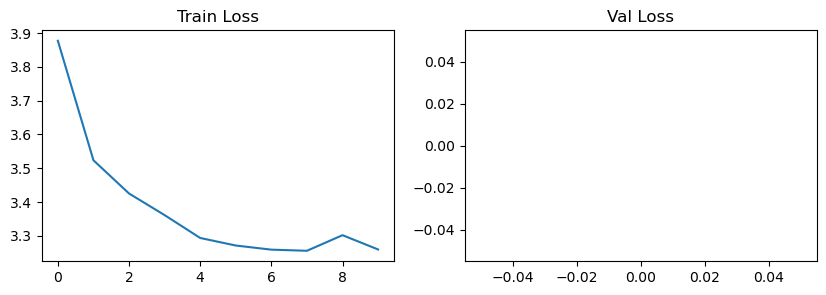

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(train_loss_history)
axes[0].set_title('Train Loss')
axes[1].plot(val_loss_history)
axes[1].set_title('Val Loss')

In [7]:
model.eval()
model.fc = nn.Identity()

valloader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=4)

embeddings = np.zeros((len(valloader), 2048))
labels = np.zeros(len(valloader))
stratum = np.zeros(len(valloader))

with torch.no_grad():
    for i, (images, label, strata) in enumerate(tqdm(valloader)):
        images, label = images.to(device), label.to(device)
        features = model(images)
        embeddings[i: (i + 1)] = features.cpu().numpy()
        labels[i: (i + 1)] = label.cpu().numpy()
        stratum[i: (i + 1)] = strata.item()

100%|██████████| 1199/1199 [00:08<00:00, 135.92it/s]


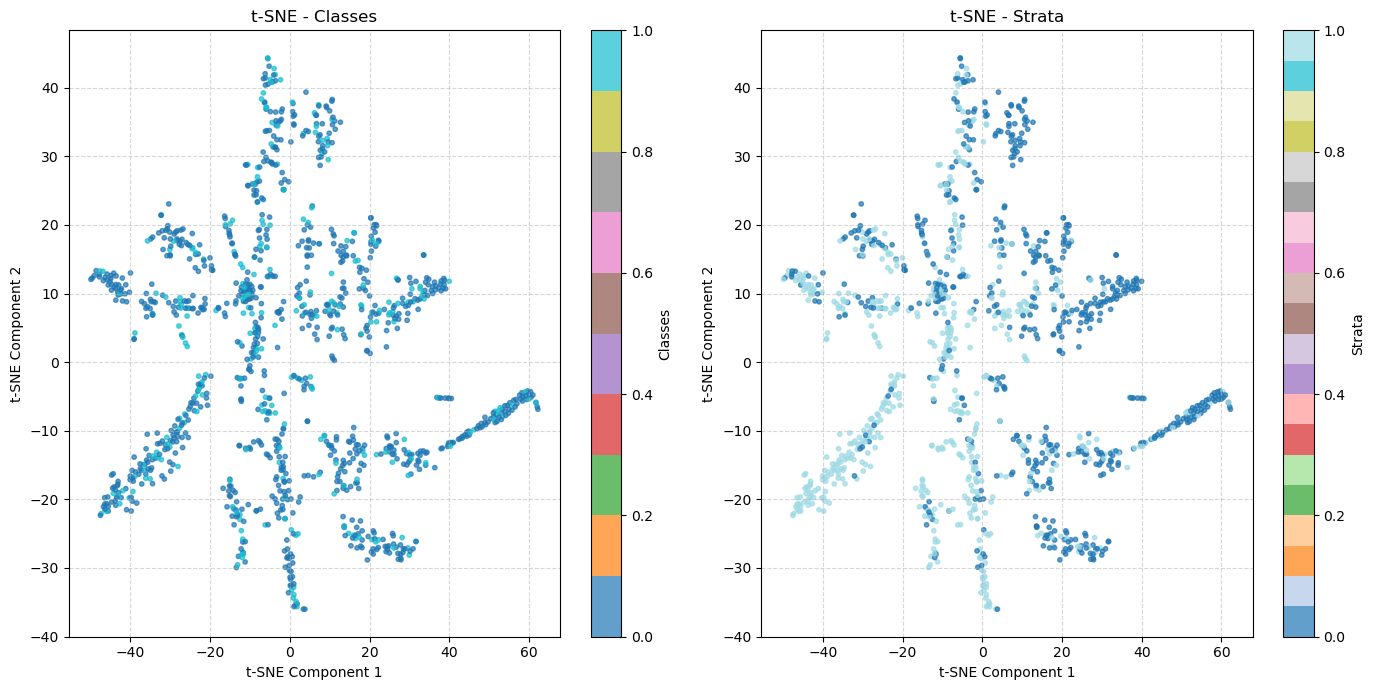

In [8]:
tsne_visualization(embeddings, labels, stratum, title="t-SNE")

In [11]:
model.fc = nn.Linear(2048, 2)
model.fc = model.fc.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
train_accuracy = []
val_accuracy = []

trainloader, valloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4), DataLoader(valset, batch_size=256, shuffle=False, num_workers=4)

In [12]:
for epoch in range(epochs):
    model.fc.train()
    train_loss = 0
    total_steps = 0
    correct = 0
    total = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_accuracy.append(correct / total)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}, Accuracy: {correct / total}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps = 0
        correct = 0
        total = 0
        for i, (images, labels, _) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total_steps += 1
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        val_accuracy.append(correct / total)
    
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}, Val Accuracy: {correct / total}')

100%|██████████| 19/19 [00:05<00:00,  3.73it/s]

Epoch: 0, Loss: 0.32450534560178457, Accuracy: 0.9762252346193953


Epoch: 0, Val Loss: 1.186890196800232, Val Accuracy: 0.6422018348623854


100%|██████████| 19/19 [00:05<00:00,  3.59it/s]

Epoch: 1, Loss: 0.19050405997979014, Accuracy: 0.983941605839416


Epoch: 1, Val Loss: 1.3742769479751586, Val Accuracy: 0.6430358632193495


100%|██████████| 19/19 [00:05<00:00,  3.56it/s]

Epoch: 2, Loss: 0.16842626427349291, Accuracy: 0.983941605839416


Epoch: 2, Val Loss: 1.4099086046218872, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.65it/s]

Epoch: 3, Loss: 0.15912291917361712, Accuracy: 0.9837330552659019


Epoch: 3, Val Loss: 1.4775241374969483, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.80it/s]

Epoch: 4, Loss: 0.15409271536689056, Accuracy: 0.9837330552659019


Epoch: 4, Val Loss: 1.5125725507736205, Val Accuracy: 0.6472060050041701


100%|██████████| 19/19 [00:05<00:00,  3.72it/s]

Epoch: 5, Loss: 0.14657371608834519, Accuracy: 0.9837330552659019


Epoch: 5, Val Loss: 1.573876929283142, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]

Epoch: 6, Loss: 0.14416752716428355, Accuracy: 0.9837330552659019


Epoch: 6, Val Loss: 1.6304177522659302, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.76it/s]

Epoch: 7, Loss: 0.14084959187005697, Accuracy: 0.9837330552659019


Epoch: 7, Val Loss: 1.6632638216018676, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.58it/s]

Epoch: 8, Loss: 0.1382275027664084, Accuracy: 0.9837330552659019


Epoch: 8, Val Loss: 1.686548686027527, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]

Epoch: 9, Loss: 0.13584506041125247, Accuracy: 0.9837330552659019


Epoch: 9, Val Loss: 1.7326897859573365, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.65it/s]

Epoch: 10, Loss: 0.13472230301091545, Accuracy: 0.983941605839416


Epoch: 10, Val Loss: 1.783708882331848, Val Accuracy: 0.6455379482902419


100%|██████████| 19/19 [00:05<00:00,  3.72it/s]

Epoch: 11, Loss: 0.13164799542803512, Accuracy: 0.9837330552659019


Epoch: 11, Val Loss: 1.7589234828948974, Val Accuracy: 0.6480400333611342


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]

Epoch: 12, Loss: 0.13088633825904444, Accuracy: 0.9837330552659019


Epoch: 12, Val Loss: 1.847634983062744, Val Accuracy: 0.646371976647206


100%|██████████| 19/19 [00:05<00:00,  3.74it/s]

Epoch: 13, Loss: 0.1296334517629523, Accuracy: 0.983941605839416


Epoch: 13, Val Loss: 1.8444671392440797, Val Accuracy: 0.6472060050041701


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]

Epoch: 14, Loss: 0.12985944198934654, Accuracy: 0.983941605839416


Epoch: 14, Val Loss: 1.8825922966003419, Val Accuracy: 0.6472060050041701


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]

Epoch: 15, Loss: 0.1269599552217283, Accuracy: 0.9837330552659019


Epoch: 15, Val Loss: 1.8651397943496704, Val Accuracy: 0.6497080900750626


100%|██████████| 19/19 [00:05<00:00,  3.75it/s]

Epoch: 16, Loss: 0.1257773198579487, Accuracy: 0.983941605839416


Epoch: 16, Val Loss: 1.9262224674224853, Val Accuracy: 0.6472060050041701


100%|██████████| 19/19 [00:05<00:00,  3.75it/s]

Epoch: 17, Loss: 0.12501081314526105, Accuracy: 0.983941605839416


Epoch: 17, Val Loss: 1.9111961841583252, Val Accuracy: 0.6480400333611342


100%|██████████| 19/19 [00:04<00:00,  3.84it/s]

Epoch: 18, Loss: 0.12486918035306428, Accuracy: 0.9837330552659019


Epoch: 18, Val Loss: 1.944675326347351, Val Accuracy: 0.6480400333611342


100%|██████████| 19/19 [00:05<00:00,  3.75it/s]

Epoch: 19, Loss: 0.12351957512529273, Accuracy: 0.983941605839416


KeyboardInterrupt: 